# Worksheet 11: Predictive versus generative modelling


### Learning objectives
By the end of this section, students will be able to:

- Give examples of questions that can be answered by generative models and others that can be answered by predictive models.
- Discuss how the research question being asked impacts the statistical modelling procedures.
- Discuss why the model obtained directly from lasso is not the most suitable model for generative modelling and how post-lasso is one way to address this problem.
- Write a computer script to perform post-lasso and use it to estimate a generative model.
- Discuss post inference problems (e.g., double dipping into the data set) and current practical solutions available to address these (e.g., data-splitting techniques).
- Write a computer script to apply currently available practical solutions to post inference problems.
- Discuss how the research question being asked impacts the communication of the results.


In [1]:
library(tidyverse)
library(glmnet)
library(broom)
library(leaps)
library(repr)
library(faraway)
library(mltools)

options(repr.plot.width=10, repr.plot.height=8)
source("tests_worksheet_11.r")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-2


Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na



Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches




# Introduction

## 1. Statistical Modelling

In statistical modelling, the objective is to capture how a response variable, $Y$, is associated with a set of input variables, $\mathbf{X}=\left(X_1, X_2, ..., X_p\right)$. There are two main reasons that motivate us to model the relationship between $\mathbf{X}$ and $Y$: (1) prediction; and (2) inference. 

### 1.1 Prediction

Everyone is familiar with the usefulness of prediction. In fact, we are constantly making predictions on a daily basis. For example, 
You look at the weather outside and decide whether you should bring an umbrella with you or not. 
When you are driving and see a pedestrian approaching the street, you predict whether the pedestrian will walk in front of your car or wait. Many variables could affect the response here (i.e., whether the pedestrian will cross the street), such as, whether the pedestrian saw your car, if the pedestrian thinks you are going to stop on time, how late the pedestrian is to arrive at his/her destination, etc.
When you have to go to an appointment, you predict how long it will take to arrive at your destination. Many variables could affect your response: Was there an accident in the way? Is there a construction site in the way? What time of the day is your appointment? 
These examples are very informal prediction processes. You make a judgment call based on your knowledge and past experiences.  Not very scientific, but still useful predictions! 

Statistical modelling, however, will allow you to model the relationship between the response variable and the covariates considered to be associated with it, based on data. Besides being less subjective and providing you with a methodologically sound way to learn about the relationship between $Y$ and $\mathbf{X}$, statistical modelling has the crucial advantage of also giving you a measure of uncertainty. A few examples of questions questions that can be answered with prediction: 

- How much will be the selling price of a house with three bedrooms, 1300 sq. feet in Kitsilano? 
- Given that my blood albumin level is 44g/L, do I have a liver problem?
- What will be my final grade in STAT 301, given that I'm studying 5 hours per week and got 85% in the midterm? 
- Is there a difference in final grades between two sessions of a course: one online and the other in-person? 


#### Linear Regression as a Predictor

- The conditional expectation is the best predictor of $Y$ given a vector of variables $\boldsymbol{X}$: $E[Y|\boldsymbol{X}]$


- A LR assumes a linear form for this conditional expectation

    - In general, this is only an *assumed* model, an *approximation* to the real form of $E[Y|\boldsymbol{X}]$


- If the conditional expectation is not linear, the LR can still be used as a predictor of $Y$ but it may not be the *best* one!
    - For example, in DSCI100 you have used kNN to estimate the conditional expectation

### 1.2 Inference

In some cases, we are interested in understanding the association between $Y$ and $\mathbf{X}$. We want to know how $Y$ varies when $\mathbf{X}$ changes. For example,

- How does price affect the sales of iPhones?
- What affects the price of a house more: the number of bedrooms or the number of bathrooms? 
- Is $\text{CO}_2$ associated with temperature elevation? 
- Does the sex of the applicants influence the chance of admission at the University of British Columbia?
- Has the social distancing measures influenced the spread of COVID-19 in Canada?

In all the questions above, we are not primarily interested in making highly accurate predictions. Instead, we want to understand the relation between different variables. 

Naturally, in many cases, we are interested in both: inference and prediction. For example, one could be interested in answering "How do social distancing measures influence the spread of COVID-19?" but also in answering  "How many cases can we expect to have if we implement some social distancing policies?". Linear Models are an excellent initial approach in these cases, as they are highly interpretable and still perform reasonably well in many cases. 

As we move to more complex models, such as Neural Networks, we **might** obtain much higher prediction performance, but their interpretation is quite tricky, if possible at all.  Notwithstanding, if we are only interested in accurate predictions, these models can be extremely useful. For example, a bakery manager wants to know how many apple pies will be sold the next day in order to know how many to prepare today. In this case, it doesn't matter how they get the prediction, as long as the prediction is close. Otherwise, they miss sales if the forecast is too small; they lose money by throwing out too many pies if the forecast is too high. No matter how complex these models are, we can always estimate their prediction performance using strategies such as cross-validation. 

In other situations, however, our primary interest is in inference, i.e., in understanding the relationship between the response and the covariates. In these cases, we are willing to sacrifice some prediction performance for a more interpretable model that correctly depicts the variables' relationship. We are concerned about obtaining good estimates for the parameters of the models. 

<font color="blue">**This week we will continue learning how to build and evaluate generative and predictive models.**</font> 

# PART I: Model selection (cont.)

## In worksheet_08: 

### Select a model using *stepwise* algorithms

- these are *greedy* algorithms 

- results depend on the order in which variables are selected 

- variables are either *in* (i.e., estimated coefficient different from zero) or *out* (i.e., estimated coefficient equal to zero)

#### Instead, can we *smoothly* transition from a $0$ estimated coefficient to an estimated coefficient with a value different from $0$?

Let's illustrate idea this with data:

## Dataset

In this section we will work with a richer real estate dataset, the [Ames `Housing` dataset](https://www.kaggle.com/c/home-data-for-ml-course/), compiled by Dean De Cock. It has 79 input variables on different characteristics of residential houses in Ames, Iowa, USA that can be used to predict the property's final price, `SalePrice`. We will use a subset of 21 continuous input variables:

- `LotFrontage`: Linear $\text{ft}$ of street connected to the house.
- `LotArea`: Lot size in $\text{ft}^2$.
- `MasVnrArea`: Masonry veneer area in $\text{ft}^2$.
- `TotalBsmtSF`: Total $\text{ft}^2$ of basement area.
- `GrLivArea`: Above grade (ground) living area in $\text{ft}^2$.
- `BsmtFullBath`: Number of full bathrooms in basement.
- `BsmtHalfBath`: Number of half bathrooms in basement.
- `FullBath`: Number of full bathrooms above grade.
- `HalfBath`: Number of half bathroom above grade.
- `BedroomAbvGr`: Number of bedrooms above grade (it does not include basement bedrooms).
- `KitchenAbvGr`: Number of kitchens above grade.
- `Fireplaces`: Number of fireplaces.
- `GarageArea`: Garage's area in $\text{ft}^2$.
- `WoodDeckSF`: Wood deck area in $\text{ft}^2$.
- `OpenPorchSF`: Open porch area in $\text{ft}^2$.
- `EnclosedPorch`: Enclosed porch area in $\text{ft}^2$.
- `ScreenPorch`: Screen porch area in $\text{ft}^2$.
- `PoolArea`: Pool area in $\text{ft}^2$.

The following variables will be used to construct a variable `ageSold`
- `YearBuilt`: Original construction date.
- `YrSold`: Year sold.

Run this code to prepare a working dataset

In [2]:
Housing <- read_csv("data/Housing.csv")

# Use `YearBuilt` and `YrSold` to create a variable `ageSold`
Housing$ageSold <- Housing$YrSold - Housing$YearBuilt


# Select subset of input variables
Housing <- Housing %>%
  select(
    LotFrontage, LotArea, MasVnrArea, TotalBsmtSF, 
    GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, Fireplaces,
    GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, ScreenPorch, PoolArea, ageSold, SalePrice
  )


# Remove those rows containing `NA`s and some outliers
Housing <- drop_na(Housing)  %>% 
            filter(LotArea < 20000)

Rows: 1460 Columns: 81
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (43): MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConf...
dbl (38): Id, MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, Ye...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
set.seed(1234)

Housing$ID <- 1:nrow(Housing)
training_Housing <- sample_n(Housing, size = nrow(Housing) * 0.60,
  replace = FALSE
)

testing_Housing <- anti_join(Housing,
  training_Housing,
  by = "ID"
)

# I now remove the ID variable

training_Housing <- training_Housing %>% select(-"ID")
testing_Housing <- testing_Housing %>% select(-"ID")

#### In the following example, I use only the first 5 covariates to simplify the presentation

Run these cells to fit the "forward" selection algorithm on this (smaller) training set:

In [4]:
Housing_forward_sel <- regsubsets(
  x = SalePrice ~ ., nvmax = 19,
  data = training_Housing,#[,c(1:5,20)],
  method = "forward",
)

coef(Housing_forward_sel,1) %>% round(3)
coef(Housing_forward_sel,2) %>% round(3)
coef(Housing_forward_sel,3) %>% round(3)

(Intercept)   GrLivArea 
   4704.059     116.413

(Intercept)   GrLivArea     ageSold 
  64267.135     102.473   -1055.232

(Intercept) TotalBsmtSF   GrLivArea     ageSold 
  20414.712      58.651      84.120    -782.596

The estimated coefficient for `ageSold` "jumps" from 0 to -1055.232. Similarly for other coefficients in other steps. 

### Can the selection be done more "smoothly"??

## 1. Shrinkage (aka regularized or penalized) methods!!


They shrink coefficients in a continuous way by adding a bound to their size!! 

$$
\ \min_{\beta_0, \boldsymbol{\beta}} \ \sum_{i=1}^n \left(Y_i - \beta_0 - \boldsymbol{X}_i \boldsymbol{\beta} \right)^2
$$
#### subject to
$$
\text{size of coefficients} \le \ C \; \text{ for some } C > 0.
$$


![](https://github.com/UBC-STAT/stat-301/blob/master/materials/worksheet_11/img/shrink.png?raw=true)

### 1.1 Mathematically

<font color="blue"> **Shrinkage methods minimize the residual sum of squares subject to a bound on the size of the coefficients (see picture)**
    
**Measuring size**

We'll focus on 2 methods to measure the size of the coefficients (but there are many others that have been used and studied):


- **Ridge** uses an $L_2-$norm to measure the size of the coefficients $$\lVert \beta \rVert_2^2 = \sum_{j = 1}^{p} \beta_j^2.$$


- **Lasso** uses an $L_1-$norm to measure the size of the coefficients $$\lVert \beta \rVert_1 = \sum_{j = 1}^{p} |\beta_j|.$$

#### LASSO: Least Absolute Shrinkage and Selection Operator

- Proposed in 1996 by Tibshirani in \emph{JRSS}

- It *does* shrink coefficients to $0$, thus it can be used to *simultaneously select and train (estimate)* a model!!

- It has been proposed to build strong predictive models

**LASSO minimizes:**

$$
\ \min_{\beta_0, \boldsymbol{\beta}} \ \sum_{i=1}^n \left(Y_i - \beta_0 - \boldsymbol{X}_i \boldsymbol{\beta} \right)^2
$$
#### subject to
$$
\sum_{j=1}^p \, |\beta_j| \ \le \ C \; \text{ for some } C > 0.
$$


This is mathematically equivalent to minimizing a *penalized* RSS:

$$
\sum_{i=1}^n \left(Y_i - \beta_0 - \boldsymbol{X}_i \boldsymbol{\beta} \right)^2 + \ \lambda \ \sum_{j=1}^p \, |\beta_j| \
$$

### Ridge

- Proposed in 1970 by Hoerl, A.E. and Kennard, R. in \emph{Technometrics}


- It does not shrink parameters to $0$, so it does *not* select variables 


- It has been proposed as a method to address multicollinearity problems (we'll skip the math)

**Ridge minimizes:**

$$
\ \min_{\beta_0, \boldsymbol{\beta}} \ \sum_{i=1}^n \left(Y_i - \beta_0 - \boldsymbol{X}_i \boldsymbol{\beta} \right)^2
$$
#### subject to
$$
\sum_{j=1}^p \, \beta_j^2 \ \le \ C \; \text{ for some } C > 0.
$$


This is mathematically equivalent to minimizing a *penalized* RSS:

$$
\sum_{i=1}^n \left(Y_i - \beta_0 - \boldsymbol{X}_i \boldsymbol{\beta} \right)^2 + \ \lambda \ \sum_{j=1}^p \, \beta_j^2 \
$$

### 1.2 How much to shrink?? the penalty parameter

Mathematically, the problem is equivalent to minimizing a *penalized* RSS. For example, LASSO minimizes

$$
\sum_{i=1}^n \left(Y_i - \beta_0 - \boldsymbol{X}_i \boldsymbol{\beta} \right)^2 + \ \lambda \ \sum_{j=1}^p \, |\beta_j| \
$$

- The additional term $\lambda \sum_{j = 1}^{p} |\beta_j|$ is the *penalty* term, and $\lambda$ is called the *penalty parameter*. 


- If $\lambda = 0$, this objective function is the same as that of LS!! Same estimators!! 



- As $\lambda$ grows, coefficients are shrunk towards $0$ 

    - LASSO eventually shrinks them all to zero 
    - Ridge will never reach a value of zero 
    
    
- The penalty parameter $\lambda$ can be selected using the data. This process is called "tuning".

    - an option is to select the value that yields the smallest $\text{MSE}_{\text{test}}$. 
    - this tuning is done using an internal cross-validation or a validation set so that the model does not use *test* data
    
> This "shrinkage" process biases the estimated coefficients! We sacrifice bias for a lower variance to gain prediction performance!!

**Important remark:** since the method depends on the *size* of the coefficients, we need to standardize the input variables (default option)

### 1.3 In R:

To train a regression using LASSO we can use the package `glmnet` in `R`

For LASSO, we set `alpha = 1`. For Ridge, we set `alpha = 0`. 

> There are infinite other options in between known as *Elastic Net* 

1. `glmnet` requires: a matrix with input variables and a vector of responses


2. we can find an "optimal" value of $\lambda$ using the function `cv.glmnet()` 

> CV creates many *test sets* from the training set 

> we can define a **sequence**, grid, of values of $\lambda$ to evaluate and choose from (optional)

3. we can visualize how the estimated test-MSE changes for different values of $\lambda$

Run the code below to perform these steps

In [5]:
Housing_X_train <- training_Housing %>% select(-"SalePrice")  %>% as.matrix()


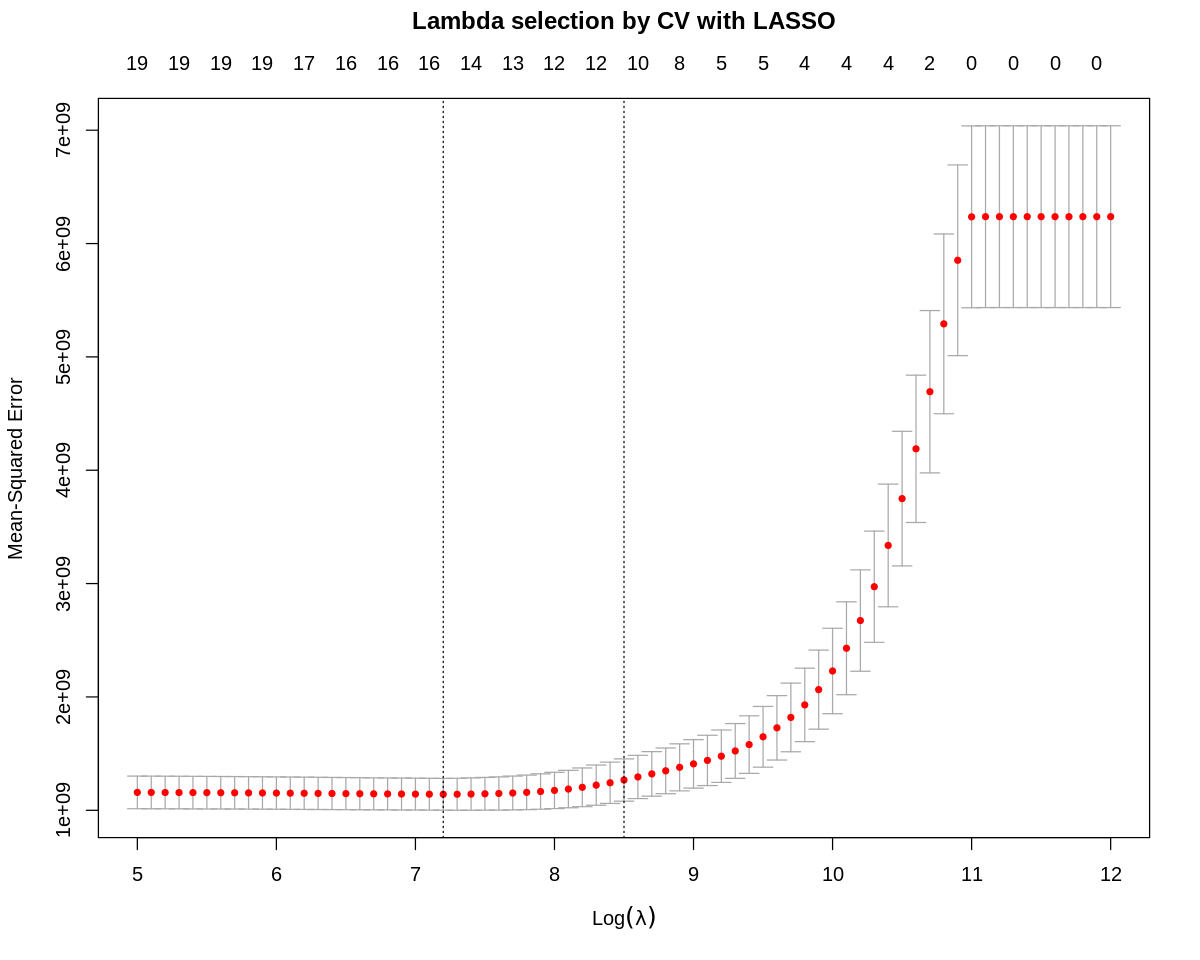

In [6]:
Housing_X_train <- training_Housing %>% select(-"SalePrice")  %>% as.matrix()
Housing_Y_train <- training_Housing %>% select("SalePrice")  %>% as.matrix()


Housing_X_test <- testing_Housing %>% select(-"SalePrice")  %>% as.matrix()
Housing_Y_test <- testing_Housing %>% select("SalePrice")  %>% as.matrix()

Housing_cv_lambda_LASSO <- cv.glmnet(
  x = Housing_X_train, y = Housing_Y_train,
  alpha = 1,
  lambda = exp(seq(5, 12, 0.1))
)

plot(Housing_cv_lambda_LASSO, main = "Lambda selection by CV with LASSO\n\n")

The plot shows the *estimated* test-MSE ($y$-axis) for a grid of values of $\lambda$ ($x$-axis) on the natural log-scale. 

> the numbers at the top $x$-axis indicate the number of inputs whose estimated coefficients are different from zero for different values of $\lambda$. 

> the error bars represent the variation across the different test sets of the CV (folds)

The two vertical dotted lines correspond to two values of $\lambda$:

- $\hat{\lambda}_{\text{min}}$ which provides the minimum MSE in the grid.


- $\hat{\lambda}_{\text{1SE}}$ largest value of lambda such that the corresponding MSE is within 1 standard error of that of the minimum (more penalization at a low cost)

Run the code below to obtain $\hat{\lambda}_{\text{min}}$ and call it `Housing_lambda_min_MSE_LASSO`

In [7]:
Housing_lambda_min_MSE_LASSO <- round(Housing_cv_lambda_LASSO$lambda.min, 4)

round(Housing_lambda_min_MSE_LASSO,2)
round(log(Housing_lambda_min_MSE_LASSO),2)

[1] 1339.43

[1] 7.2

#### LASSO "smoothly" selects variables and trains the corresponding model !

> for values of lambda in the grid

Run the code below to visualize the estimated regression coefficients over the $\lambda$-grid

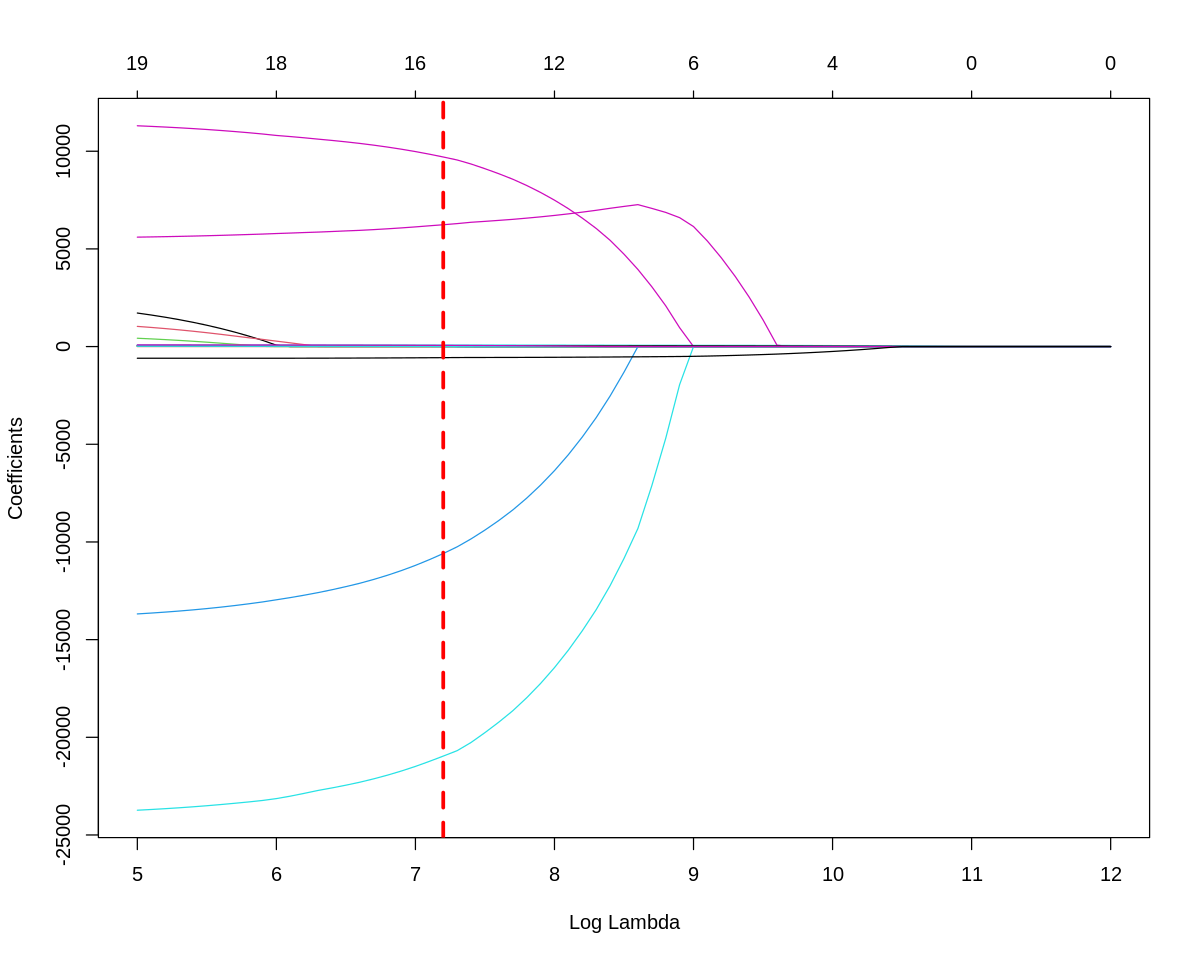

In [8]:
plot(Housing_cv_lambda_LASSO$glmnet.fit, "lambda")
abline(v = log(Housing_lambda_min_MSE_LASSO), col = "red", lwd = 3, lty = 2)

We can compare the coefficients of the selcted model (for $\hat{\lambda}_{\text{min}}$) with those of the full LS

In [9]:
set.seed(1234)

# Full LS

Housing_full_OLS <- lm(SalePrice ~ .,
data = training_Housing
)

# LASSO
Housing_LASSO_min <- glmnet(
  x = Housing_X_train, y = Housing_Y_train,
  alpha = 1,
  lambda = Housing_lambda_min_MSE_LASSO
)

Housing_LASSO_min.coef <- Housing_LASSO_min$beta

Housing_reg_coef <- round(cbind(
  Full_OLS = coef(Housing_full_OLS),
  LASSO_min = c(
    Housing_LASSO_min$a0,
    as.vector(Housing_LASSO_min.coef)
  )
), 4)

Housing_reg_coef

Full_OLS    LASSO_min  
(Intercept)    48613.1809  46022.9963
LotFrontage       55.7394     12.8991
LotArea            1.4823      1.3038
MasVnrArea        22.5247     19.4150
TotalBsmtSF       38.3265     39.5622
GrLivArea         83.5218     81.0658
BsmtFullBath   11597.3166   9708.7097
BsmtHalfBath    2681.8555      0.0000
FullBath        1543.3771      0.0000
HalfBath         747.0520      0.0000
BedroomAbvGr  -14105.4177 -10606.0651
KitchenAbvGr  -24089.4882 -20991.6451
Fireplaces      5491.2265   6223.4659
GarageArea        35.6965     38.4949
WoodDeckSF        28.0045     20.5872
OpenPorchSF       24.6968     10.4994
EnclosedPorch     46.3088      5.9356
ScreenPorch       27.0443      4.1628
PoolArea          89.4663     63.3741
ageSold         -596.7286   -565.7057

### 1.4 Model selection and Prediction

These models can be used to predict *new* data (out-of-sample)

Many penalized estimators, including LASSO, have been proposed to build strong predictive models. Thus, they are tuned by minimizing a test-MSE.

In [10]:
# Full LS predictions

Housing_test_pred_full_OLS <- predict(Housing_full_OLS, newdata = testing_Housing)

In [11]:
# LASSO predictions

Housing_test_pred_LASSO_min <- predict(Housing_LASSO_min,
  newx = Housing_X_test)

In [12]:
# Comparison

Housing_R_MSE_models <- rbind(tibble(
  Model = "OLS Full Regression",
  R_MSE = rmse(
    preds = Housing_test_pred_full_OLS,
    actuals = testing_Housing$SalePrice
  )
),
    tibble(
    Model = "LASSO Regression with minimum MSE",
    R_MSE = rmse(
      preds = Housing_test_pred_LASSO_min,
      actuals = testing_Housing$SalePrice
    )
  )
)

Housing_R_MSE_models

Model                             R_MSE   
1 OLS Full Regression               34686.05
2 LASSO Regression with minimum MSE 35058.23

#### In this example the full LS model has a better prediction performance than LASSO

> results may depend on the split of the data. We need to make several splits to assess these models

### 1.5 Conclusions

- Shrinkage methods can be used to select variables to build a model depending on the penalty function used

- Shrinkage methods shrink coefficients in a continuous way by adding a bound to their size!!

- In general, they are tuned to build predictive models. Penalty levels are chosen so that the CV-MSE is minimized (or low enough)

- LASSO is a well known example that penalized the RSS with an $L_1$ penalty

    - coefficients can be shrunk to 0
    
- Ridge is a well known example that penalized the RSS with an $L_2$ penalty

    - coefficients won't be shrunk to 0
    
    - it was first proposed to address problems of multicollinearity

## PART II: Model Selection and Inference

There are many aspects involved in selecting a model that goes beyond variable selection, for example,

- Do we want a parametric or non-parametric approach? 
- Do we want to assume a functional form for the relationship between $Y$ and $\mathbf{X}$ (e.g., linear, quadratic, exponential, logarithmic)?
- Prediction performance. 
- Is model interpretability important?

In previous lectures, we have discussed different ways of selecting models for estimation problems in which the interpretability of the model is crucial, as well as for prediction problems.

In particular, we have learned many ways of comparing: (1) $R^2$, (2) adjusted $R^2$, (3) BIC, (4) Cp, among others.

We also explored different techniques to select a desired model:

- F-test

- Stepwise Algorithms (e.g., Forward Selection, Backward Selection)

- Penalized methods (e.g. LASSO)

#### Can we still make inference using the selected models??

In this course, we learned how to make inference (e.g, calculate confidence interval and hypotheses tests) for a fixed model. However, when we apply any of these model selection methods, we are searching for the combination of variables that will give us the best model (according to a given metric). So the variables in our final models are not fixed; instead, they are selected adaptively based on **the data at hand**. 

Two questions arise then: 

1. Do these model selection algorithms affect the inference about the parameters of the model? 

2. Is the way we interpret the models still the same? 

Now we will investigate the first question. For now, let's focus on the forward selection. 

#### Forward Selection Review
Suppose we have $p$ covariates $X_1, X_2,\ldots,X_p$ to explain our response $Y$. The full model is given by:

$$
Y_i = \beta_0 + \beta_1 X_{i1} + \ldots + \beta_p X_{ip} + \varepsilon
$$

We want to find the best subset of variables to explain $Y$. Searching the best subset using brute force would require us to fit prohibitive number of models to compare (see table below).

| number of covariates (*p*) | Number of possible models |
| ---------------------------|-------------------:|
| 10 | 1,024 |
| 20 | 1,048,576 |
| 30 | 1,073,741,824 |


The forward selection strategy helps us to find good models among the insane numbers of models shown in the table above. But, unfortunately, it is not guaranteed to find the best model (or even good models). 

It starts with the **null model** (i.e., a model with no covariates, only the intercept $\beta_0$):

$$
\mathbf{Y} = \beta_0 + \epsilon
$$

Then, among the remaining variables, it searches for the one that improves the model the most and incorporates the variable into to the model. It keeps incorporating one variable at a time until there's no variable left that would improve the model. 

But what do we mean by "improves the model the most?" - There are different criteria one can use to "measure" this. Common choices are $C_p$, *AIC*, *BIC*, *F-test*.

**Question 2.1**<br>

In this exercise, we will explore if the forward selection strategy affects the model inference. For this purpose, we are going to use simulation in order for us to know the truth. Here's what we are going to do: 

1. We are going to consider a response variable $Y$ and $p=10$ covariates. However, none of the covariates will have any effect on $Y$; they are all independent. (we already know the truth)


2. Generate 100 observations of each variable from a normal distribution.


3. Apply only the first step of forward selection. In other words, we are looking to add the first variable only among ten potential candidates.
    - The metric we are going to use is the F statistic.


4. `replicate` this study 1,000 times and measure the errors.

We have already simulated the data for you (Steps 1 and 2 above) in the cell below. 

In [13]:
# Run this cell before continuing 
set.seed(20211113)

n <- 100    # sample size
p <- 10     # number of variables
rep <- 1000 # number of replications

means <- runif((p+1), 3, 10) # the mean that will be used in the 
                             # Normal distribution for simulation.
                             # The +1 refers to Y.  

dataset <- as_tibble(
  data.frame(
    matrix(
      round(rnorm((p + 1) * n * rep, 
            means, 10), 2), 
      ncol = p+1, 
      byrow = TRUE
    )
  ) %>% 
  rename(Y = X11) %>% 
  mutate(replicate = rep(1:rep, n)) %>% 
  arrange(replicate) 
)

head(dataset)

X1    X2    X3    X4    X5    X6    X7     X8    X9    X10    Y     replicate
1  8.07  8.86 15.62  3.37  2.79  0.77   5.65 -8.65  7.52   9.39 -6.99 1        
2 -3.96  3.59 15.84  3.05  1.38 -0.01 -14.54  7.11 -9.83  -3.03 21.06 1        
3 -5.03 -2.62  7.83  9.05 11.52  9.45  -4.41 11.92 13.61  25.83 -2.80 1        
4  5.40  7.38 -1.07  2.93 31.07  8.13   5.13 19.39  9.98  -3.65  0.07 1        
5  4.61 23.21 11.92 -1.83 16.86 15.95  -5.94  8.37 13.94  13.96 -0.37 1        
6 -3.96 12.62 21.53 -1.47 -6.53  6.80  17.57 -1.70 -1.25 -16.95 23.17 1

In [43]:
dim(dataset)

[1] 100000     12

**Question 2.1.1 - Warm up**<br>
{points: 1}

To help you visualize the code abstraction, let's do a more intuitive exercise. 
Using the `dataset` tibble, fit one `lm` for each replicate using all 10 covariates to explain $Y$. Store the `lm` models in a column named `models`.

_Assign your data frame to an object called `full_models`. Your data frame should have three columns: `replicate`, `data`, and `models`._

In [14]:
# full_models <- 
#     ... %>% 
#     group_by(...) %>% 
#     nest() %>% 
#     mutate(models = map(...))


### BEGIN SOLUTION
full_models <- 
    dataset %>% 
    group_by(replicate) %>% 
    nest() %>% 
    mutate(models = map(.x = data, ~ lm(Y ~ ., data = .x)))
### END SOLUTION

# Try exploring the columns of your data frame. 
# Check full_models$data[[1]] and full_models$models[[1]]

In [45]:
full_models$models[[1]]


Call:
lm(formula = Y ~ ., data = .x)

Coefficients:
(Intercept)           X1           X2           X3           X4           X5  
    4.65857      0.05977      0.04595     -0.02462      0.14726     -0.06335  
         X6           X7           X8           X9          X10  
   -0.04047      0.08451      0.01575     -0.06840     -0.11245  


In [15]:
test_2.1.1()

Test passed 😀
Test passed 🌈
Test passed 🌈
Test passed 🌈
Test passed 🥳
[1] "Success!"


To help speed things up, we created a function for you that receives a data frame, performs the first forward selection step, and returns the F-statistic. What is the F-statistic again? In this case, the F-statistic measures if the Residuals Sum of Squares when incorporating a covariate into the model decreases significantly.

In [16]:
forward_selection_step1 <- function(dataset){
    #' Returns the F-statistic of the first
    #' step of forward selection.
    #'
    #' @param dataset the dataset to be used

    selected_model <- lm(Y ~ ., data = dataset[,c(paste("X",1, sep = ""), "Y")])
    F_selected <- glance(selected_model) %>% pull(statistic)
    
    for( j in 2:(ncol(dataset)-1) ){ # fits one lm for each covariate and calculate the F statistic 
        model <- lm(Y ~ ., data = dataset[,c(paste("X",j, sep = ""), "Y")])
        F <- glance(model) %>% pull(statistic)
        
        
        if (F > F_selected){
            F_selected <- F
            selected_model <- model
        }
    }
    return(selected_model)
}

**Question 2.1.2**<br>
{points: 1}

Using the `dataset` tibble, calculate the F-statistic of the model selected in the first step of forward selection. Store the model in a column named `fs_model`. Then, extract the F-statistic from the model and store it in a column named `F`.

_Assign your data frame to an object called `forward_selection_F`. Your data frame should have four columns: `replicate`, `data`, `fs_model`, and `F`._

In [17]:
# forward_selection_F <- 
#     ... %>% 
#     group_by(...) %>% 
#     nest() %>% 
#     mutate(
#         ... = map(...), 
#         ... = ..._dbl(...)
#     )

### BEGIN SOLUTION
forward_selection_F <- 
    dataset %>% 
    group_by(replicate) %>% 
    nest() %>% 
    mutate(
        fs_model = map(.x = data, forward_selection_step1), 
        F =  map_dbl(.x = fs_model, ~ glance(.x) %>% pull(statistic))
    )
### END SOLUTION

head(forward_selection_F, 2)

replicate
1 1        
2 2        
  data                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [18]:
test_2.1.2()

Test passed 😸
Test passed 🥇
Test passed 😸
Test passed 🥇
Test passed 🥇
[1] "Success!"


**Question 2.1.3** 
<br> {points: 1}

Suppose we want to test, at 5% significance, whether the decrease in the RSS was significant by adding the variable chosen by the forward selection strategy. In this case, $\text{F-statistic}\sim F_{1,98}$. 


What value should we compare the F-statistic against? 


_Assign your answer to an object called `F_critical`. Your answer should be a single number._

In [19]:
# F_critical <- ...

### BEGIN SOLUTION
F_critical <- qf(0.95, 1, 98)
### END SOLUTION

F_critical

[1] 3.938111

In [20]:
test_2.1.3()

Test passed 🎉
Test passed 😀
Test passed 🎉
[1] "Success!"


**Question 2.1.4** 
<br> {points: 1}

Knowing that none of our covariates are relevant to model $Y$, if we use the `F_critical` you calculated in the previous questions, what proportions of replications would you expect to wrongly reject the null hypothesis that the variable is not significant?

_Assign your answer to an object called `nominal_type_I_error`. Your answer should be a single number._

In [21]:
# nominal_type_I_error <- ...

### BEGIN SOLUTION
nominal_type_I_error <- 0.05
### END SOLUTION

nominal_type_I_error

[1] 0.05

In [22]:
test_2.1.4()

Test passed 😸
Test passed 🥳
Test passed 😸
[1] "Success!"


**Question 2.1.5** 
<br> {points: 1}

Check the proportions of F-statistics in the `forward_selection_F` tibble that are above the `F_critical` you calculated. 

_Assign your answer to an object called `forward_selection_type_I_error`. Your answer should be a single number._

In [23]:
# forward_selection_type_I_error <- ...

### BEGIN SOLUTION
forward_selection_type_I_error <- 
    forward_selection_F %>% 
    ungroup() %>% 
    summarise(mean(F>F_critical)) %>% 
    pull()
### END SOLUTION

forward_selection_type_I_error

[1] 0.407

In [24]:
test_2.1.5()

Test passed 😀
Test passed 😀
Test passed 😀
[1] "Success!"


### Class discussion 
Contrast the `forward_selection_type_I_error` and `nominal_type_I_error`. Are they similar? Why do you think this is happening. 

## 2.1 The double use of data

But the Type I Error after the forward selection was significantly higher than the nominal level of 5%? Well, if we are looking for the most relevant covariates in a dataset, it is not surprising that we frequently find these covariates significant. In our case above, the *F-statistic* compares the reduction of SSR after adding a variable. But this was not what we did. Instead, we deliberately searched among the variables for the one that had the highest F-statistic. In this sense, we are not testing the inclusion of **a** variable; we are testing the inclusion of  **the** variable that yields the largest F-statistic **in the sample at hand**. Hence, we have a much higher chance of wrongly rejecting $H_0$.  

Ok, we identified the problem: we are using the same sample to find the variable that yields the largest test statistic **in the sample we have**. 

But what if we split the dataset into two parts, one used for model selection and the other used for inference (similarly to what we've done in cross-validation)? Would that solve the problem? Let's investigate! 



**Question 2.2** 
<br> {points: 1}

In this exercise we are again going to use the tibble `dataset`. But this time we are going to split our dataset into two parts. One part we are going to use for inference, and the other part we are 
going to use for inference. For this exercise, let's split the dataset in half. 

Here's what you need to do: 

1. Shuffle the dataset, so we know that the observations are in random order. 

2. Using the first 50 observations, apply the first step of forward selection; store the selected model in `fs_model` column. Also, extracts the F-statistic of the `fs_model` and stores it in a column called `F_fs`.

3. Fit the model selected in Step 2 using the 50 remaining observations and save it in a column named `inference_model`. Also, extracts the F-statistic of the `inference_model` and stores it in a column called `F_inference`. 

_Assign your data frame to an object called `fs_error_split`. Your data frame should have 6 columns: `replicate`, `data`, `fs_model`, `F_fs`, `inference_model`, `F_inference`._

In [25]:
set.seed(20211113) # Do not change this.

# fs_error_split <- 
#     ... %>% 
#     sample_n(...) %>%
#     ... %>% 
#     ... %>% 
#     mutate(
#         fs_model = ...(..., .f = function(d) forward_selection_step1(d %>% head(50))), 
#         F_fs = ...,
#         inference_model = map2(.x = ..., .y = ..., ~ update(.y, .~., data = .x %>% tail(50))), 
#         F_inference =  ...)
#     )

### BEGIN SOLUTION
fs_error_split <- 
    dataset %>% 
    sample_n(size = nrow(.)) %>% 
    group_by(replicate) %>% 
    nest() %>% 
    mutate(
        fs_model = map(.x = data, function(d) forward_selection_step1(d %>% head(50))), 
        F_fs = map_dbl(.x = fs_model, ~ glance(.x) %>% pull(statistic)),
        inference_model = map2(.x = data, .y = fs_model, ~ update(.y, .~., data = .x %>% tail(50))), 
        F_inference =  map_dbl(.x = inference_model, ~ glance(.x) %>% pull(statistic))
    )
### END SOLUTION
        
head(fs_error_split) %>% 
    select(F_fs, F_inference)

Adding missing grouping variables: `replicate`


replicate F_fs     F_inference
1 279       1.653273 0.178900341
2 822       6.255837 0.805996818
3 555       1.883481 1.677012919
4 946       3.003440 0.021947105
5 427       1.163957 0.001630526
6 292       6.589227 1.968101858

In [26]:
test_2.2()

Test passed 🌈
Test passed 🎊
Test passed 😸
Test passed 🌈
Test passed 🌈
[1] "Success!"


**Question 2.3** 
<br> {points: 1}

Check the proportions of F-statistics in the `F_inference` column that are above the `F_critical` you calculated. (Hint: in this case $\text{F-statistic}\sim F_{1,48}$. 

_Assign your answer to an object called `fs_split_type_I_error`. Your answer should be a single number._

In [27]:
# fs_split_type_I_error <- ...

### BEGIN SOLUTION
fs_split_type_I_error <- 
    fs_error_split %>% 
    ungroup() %>% 
    summarise(mean(F_inference > qf(0.95, 1, 48))) %>% 
    pull()
### END SOLUTION

fs_split_type_I_error

[1] 0.048

In [28]:
test_2.3()

Test passed 😀
Test passed 🌈
Test passed 😸
[1] "Success!"


**Question 2.4**
<br>{points: 1}

True or false?

If split the data into model selection and inference split, the type I error of the F-test after the forward selection is close to the significance level. 

_Assign your answer to an object called `answer2.4`. Your answer should be either "true" or "false", surrounded by quotes._

In [29]:
# answer2.4 <- ...

### BEGIN SOLUTION
answer2.4 <- "true"
### END SOLUTION

In [30]:
test_2.4()

Test passed 😸
Test passed 🎉
Test passed 🌈
[1] "Success!"


## 2.2 Lasso - two problems

The problem we discussed with the forward selection *also happens with Lasso*. Similarly, we can address it by splitting the dataset -- one part for selecting variables using lasso and the other for fitting the model for inference. 

However, there's another problem with Lasso for inference. Lasso's estimators are biased. Bias estimators are estimators whose sampling distributions are not centred on the true value of the parameter. 

To study this problem, we are going to use a new simulation, Our population is generated below and it is store in `lasso_sim` tibble.

The population was generated such that:

$$
E[Y|X_1, X_2] = 75X_1 - 5 X_2 + 0 X_3
$$ 

Therefore, the true parameters are $\beta_1=75$ and $\beta_2=-5$. Note that $\beta_3$ is not a relevant variable and, hopefully, Lasso will remove it from the model. 

In [31]:
# Run this cell before continuing 

set.seed(20211113) # Do not change this.

n <- 1000    # sample size
rep <- 1000 # number of replications

lasso_sim <- 
    tibble(
        X1 = round(
                rnorm(n * rep, 0, 10), 
                2),
        X2 = round(
                rnorm(n * rep, 0, 10), 
                2),
        X3 = round(
                rnorm(n * rep, 0, 20), 
                2),
        Y = round(75 * X1 - 5*X2 + rnorm(n * rep, 0, 400),2)) %>% 
    mutate(replicate = rep(1:rep, n)) %>% 
    arrange(replicate) 


head(lasso_sim)

X1     X2     X3     Y        replicate
1  -9.52   6.99   6.88 -1026.24 1        
2  -4.24  10.41 -11.46  -586.31 1        
3 -21.23 -18.31  20.00  -743.30 1        
4  12.02  -7.12  -0.47   863.88 1        
5   1.88  13.89  18.47  -154.27 1        
6 -10.18  10.26  -2.86 -1063.06 1

**Question 2.5**<br>
{points: 1}

Using the `lasso_sim` tibble, fit a lasso model for each replicate using $\lambda=30$. Store the models in a column named `lasso_models`. 

_Assign your data frame to an object called `lasso_study`. Your data frame should have four columns: `replicate`, `data`, and `lasso_model`._

In [32]:
# lasso_study <- 
#     ... %>% 
#     ... %>% 
#     ... %>% 
#     mutate(
#         lasso_model = ...(...,
#                           ~...(.x %>% select(-Y) %>% as.matrix(), 
#                                   .x %>% select(Y) %>% as.matrix(), 
#                                   alpha = ..., 
#                                   lambda = ...)))

### BEGIN SOLUTION
lasso_study <- 
    lasso_sim %>% 
    group_by(replicate) %>% 
    nest() %>% 
    mutate(
        lasso_model = map(.x = data,
                          ~glmnet(.x %>% select(-Y) %>% as.matrix(), 
                                  .x %>% select(Y) %>% as.matrix(), 
                                  alpha = 1, 
                                  lambda = 30)))
### END SOLUTION

lasso_study %>% head(2)

replicate
1 1        
2 2        
  data                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [33]:
test_2.5()

Test passed 🎊
Test passed 🥇
Test passed 🎉
Test passed 🌈
Test passed 🎉
[1] "Success!"


**Question 2.6**<br>
{points: 1}

Extract the coefficient for `beta_1` from each `lasso_model` in the `lasso_study` tibble. Store the coefficent in a column name `lasso_beta1` in the same `lasso_study` tibble. 

In [34]:
# lasso_study <- 
#     ... %>% 
#     ...

### BEGIN SOLUTION
lasso_study <- 
    lasso_study %>% 
    mutate(lasso_beta1 = map_dbl(.x = lasso_model, ~coef(.x)[2,]))
### END SOLUTION

lasso_study %>% 
    select(-data) %>% 
    head()

replicate
1 1        
2 2        
3 3        
4 4        
5 5        
6 6        
  lasso_model                                                                                                                                                                                                                               
1 17.68002, <S4 class ‘dgCMatrix’ [package “Matrix”] with 6 slots>, 2, 3, 1, 30, 0.7832518, 737570112, 4, 0, FALSE, glmnet(x = .x %>% select(-Y) %>% as.matrix(), y = .x %>% select(Y) %>% ,     as.matrix(), alpha = 1, lambda = 30), 1000 
2 7.783486, <S4 class ‘dgCMatrix’ [package “Matrix”] with 6 slots>, 2, 3, 1, 30, 0.7662044, 667895360, 4, 0, FALSE, glmnet(x = .x %>% select(-Y) %>% as.matrix(), y = .x %>% select(Y) %>% ,     as.matrix(), alpha = 1, lambda = 30), 1000 
3 -7.456994, <S4 class ‘dgCMatrix’ [package “Matrix”] with 6 slots>, 2, 3, 1, 30, 0.7575035, 672723659, 3, 0, FALSE, glmnet(x = .x %>% select(-Y) %>% as.matrix(), y = .x %>% select(Y) %>% ,     as.matrix(), alpha = 1, lambda = 30), 1000
4 -3.932344, <S4 class ‘dgCMatrix’ [package “Matrix”] with 6 slots>, 1, 3, 1, 30, 0.7613222, 704316700, 3, 0, FALSE, glmnet(x = .x %>% select(-Y) %>% as.matrix(), y = .x %>% select(Y) %>% ,     as.matrix(), alpha = 1, lambda = 30), 1000
5 -10.18447, <S4 class ‘dgCMatrix’ [package “Matrix”] with 6 slots>, 2, 3, 1, 30, 0.786506, 731148523, 4, 0, FALSE, glmnet(x = .x %>% select(-Y) %>% as.matrix(), y = .x %>% select(Y) %>% ,     as.matrix(), alpha = 1, lambda = 30), 1000 
6 -33.50037, <S4 class ‘dgCMatrix’ [package “Matrix”] with 6 slots>, 2, 3, 1, 30, 0.7619526, 714571595, 4, 0, FALSE, glmnet(x = .x %>% select(-Y) %>% as.matrix(), y = .x %>% select(Y) %>% ,     as.matrix(), alpha = 1, lambda = 30), 1000
  lasso_beta1
1 71.17269   
2 71.67783   
3 70.17038   
4 71.89095   
5 71.59488   
6 71.55317

In [35]:
test_2.6()

Test passed 😀
Test passed 🥇
Test passed 😸
Test passed 🥇
Test passed 🥇
[1] "Success!"


**Question 2.7**
<br> {points: 1}

Plot the sampling distribution of $\hat{\beta}_1$ obtained by Lasso.


_Assign your plot to an object called `lasso_beta1_sampling_dist`._

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



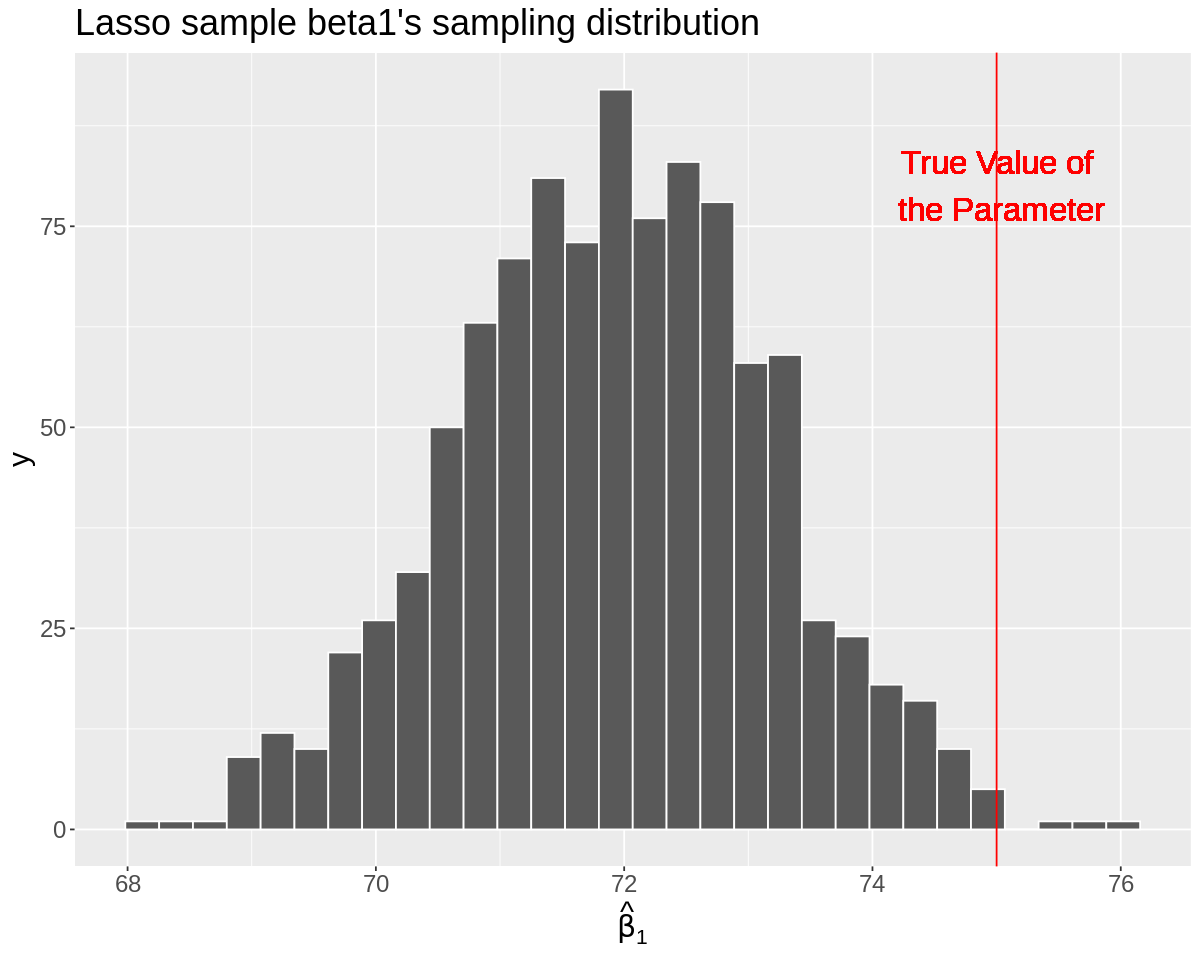

In [36]:
# lasso_beta1_sampling_dist <- 
#     lasso_study %>% 
#     ggplot() + 
#     geom_...(aes(...), color='white') +
#     geom_vline(xintercept = 75, color = 'red') + 
#     geom_text(aes(75, 110), label = "True Value of the Parameter", color = 'red') 
#     geom_text(aes(75, 80), label = "True Value of\n the Parameter", color = 'red', size = 7) +
#     theme(text = element_text(size = 18))

### BEGIN SOLUTION
lasso_beta1_sampling_dist <- 
    lasso_study %>% 
    ggplot() + 
    geom_histogram(aes(lasso_beta1), color='white') +
    geom_vline(xintercept = 75, color = 'red') + 
    geom_text(aes(75, 80), label = "True Value of\n the Parameter", color = 'red', size = 7) +
    theme(text = element_text(size = 18)) + 
    xlab(expression(hat(beta)[1])) + 
    ggtitle("Lasso sample beta1's sampling distribution")
    
### END SOLUTION

lasso_beta1_sampling_dist

In [37]:
test_2.7()

Test passed 🎉
Test passed 🎊
Test passed 🌈
Test passed 😀
Test passed 😀
Test passed 🎉
Test passed 🎉
[1] "Success!"


**Question 2.8**
<br>{points: 1}

True or false?

The sampling distribution of the lasso estimator of $\beta_1$ is centered around the true $\beta_1$.

_Assign your answer to an object called `answer2.8`. Your answer should be either "true" or "false", surrounded by quotes._

In [38]:
# answer2.8 <- ...

### BEGIN SOLUTION
answer2.8 <- "false"
### END SOLUTION

In [39]:
test_2.8()

Test passed 🥳
Test passed 🥳
Test passed 😀
[1] "Success!"


**Question 2.9**<br>
{points: 1}

Do deal with the Lasso's bias problem, we can use the variables selected by Lasso, but not the coefficients. Instead, we make a second fit using regular least squares. In the cell below we have done it for you. Here's what we did:

1. Add a new column to `lasso_study` tibble, named `lasso_selected_covariates` with the covariates selected by Lasso (i.e., with coefficients different from 0).


2. We fitted a linear model using `lm` (regular least square) and only the `lasso_selected_covariates`.


3. We extracted $\beta_1$ from the `lm` model, and saved it on a column called `ls_beta1`.

Your job is to plot the sampling distribution of $\hat{\beta}_1$ obtained by the regular least square, using the variables selected by Lasso.

_Assign your plot to an object called `post_lasso_lm_beta1_sampling_dist`._

In [40]:
# Run this cell before continuing

lasso_study <- 
    lasso_study %>% 
    mutate(
        lasso_selected_covariates = map(.x = lasso_model, 
                                        ~as_tibble(
                                                as.matrix(coef(.x)),
                                                rownames='covariate') %>%
                                                filter(covariate != '(Intercept)' & abs(s0) > 10e-6) %>% 
                                                pull(covariate)),
        ls_fit = map2(.x = data, .y = lasso_selected_covariates,
                     ~lm(Y ~ ., data = .x[,c(.y, 'Y')])),
        ls_beta1 = map_dbl(.x = ls_fit, ~tidy(.x) %>% filter(term == 'X1') %>% pull(estimate)))


lasso_study %>% 
    select(-data, -lasso_model, -ls_fit) %>% 
    head()

replicate lasso_beta1 lasso_selected_covariates ls_beta1
1 1         71.17269    X1, X2                    74.15431
2 2         71.67783    X1, X2                    74.78584
3 3         70.17038    X1, X2                    73.19749
4 4         71.89095    X1                        74.95937
5 5         71.59488    X1, X2                    74.59362
6 6         71.55317    X1, X2                    74.72685

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



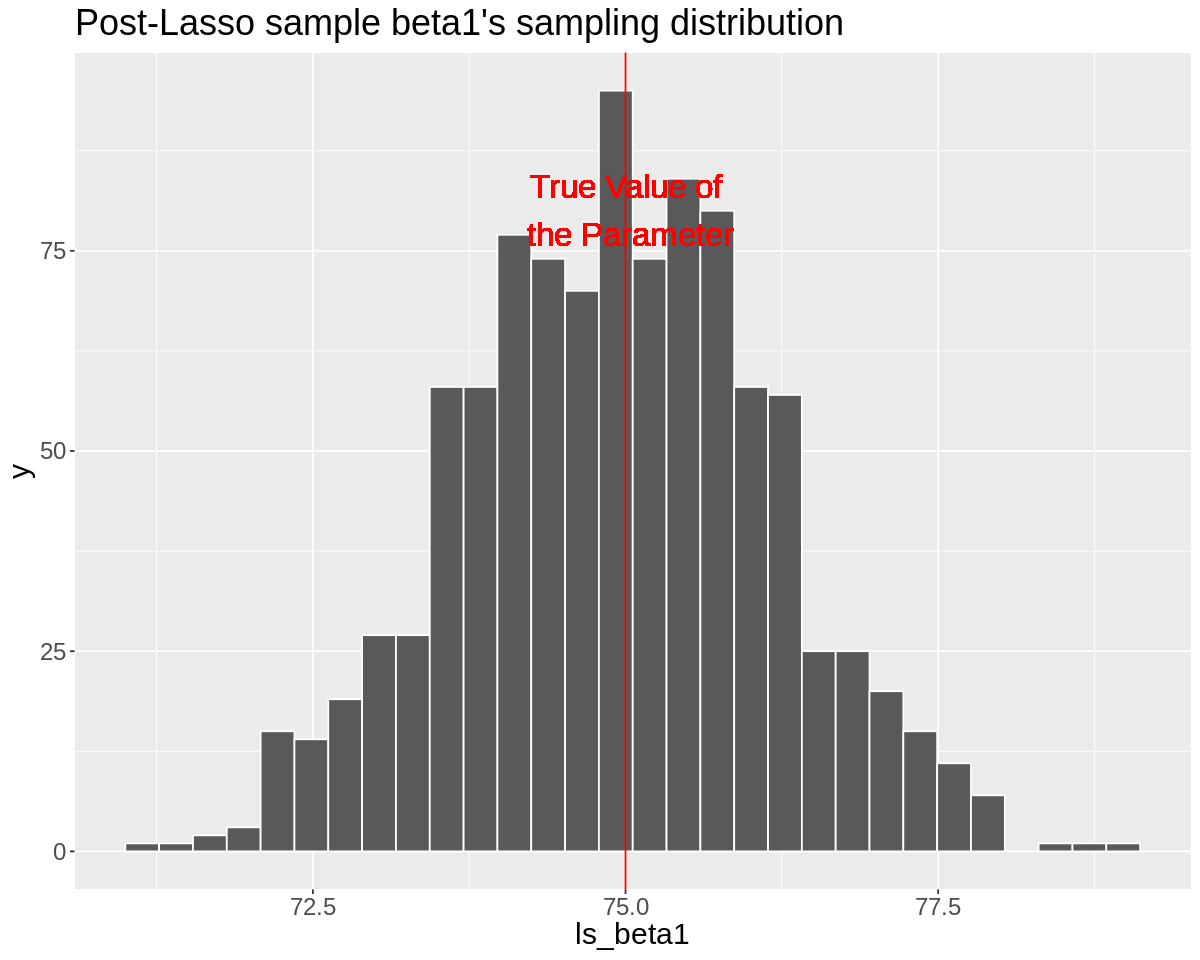

In [41]:
# post_lasso_lm_beta1_sampling_dist <- 
#     lasso_study %>% 
#     ggplot() + 
#     geom_...(aes(...), color='white') +
#     geom_vline(xintercept = 75, color = 'red') + 
#     geom_text(aes(75, 80), label = "True Value of\n the Parameter", color = 'red', size = 7) +
#     theme(text = element_text(size = 18))

### BEGIN SOLUTION
post_lasso_lm_beta1_sampling_dist <- 
    lasso_study %>% 
    ggplot() + 
    geom_histogram(aes(ls_beta1), color='white') +
    geom_vline(xintercept = 75, color = 'red') + 
    geom_text(aes(75, 80), label = "True Value of\n the Parameter", color = 'red', size = 7) +
    theme(text = element_text(size = 18)) + 
    ggtitle("Post-Lasso sample beta1's sampling distribution")
### END SOLUTION

post_lasso_lm_beta1_sampling_dist

In [42]:
test_2.9()

Test passed 🥇
Test passed 🎊
Test passed 🌈
Test passed 🎊
Test passed 🎊
Test passed 🥳
Test passed 🥳
[1] "Success!"


## 2.3 Conclusions

#### Post-inference problem:

- we can not use the same data to select variables of the model and to conduct inference ("doble dipping"). 

- the inference results given by the `lm` are not valid (as seen in the first part of the worksheet). 

- if we split the data, we can use one part to select and the other part to estimate and build tests.

- more sophisticated methods have been proposed to address this problem (beyond the scope of this course).


#### Lasso has two problems:

- **Biased estimators**: we can take care of this by fitting regular least squares on the variables selected by Lasso. This approach is called **post-lasso**.

- **Post-inference**: fitting a LS regression after Lasso, we are using the data to select the variables as well as to conduct inference. We cannot rely on the inference given by the `lm`, unless we split the data to take care of this problem.